In [1]:
import os

# Set CPU count for numpyro multi-chain multi-thread
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'

import pickle
import itertools

import jax
# Enable x64 for JAX
jax.config.update("jax_enable_x64", True)
#jax.config.update('jax_platform_name', 'cpu')

import jax.scipy as jsp
import dLux as dl
import dLux.utils as dlu
import optax
import zodiax as zdx
import jax.tree_util as jtu
import equinox as eqx
import optimistix as optx
from tqdm.notebook import tqdm

import jax.numpy as np
import jax.random as jr
from jax import jit, lax

from matplotlib import pyplot as plt
from astropy import units as u
from astropy.io import fits

#from dLux.utils import arcsec_to_rad as toRad
#from dLux.utils import rad_to_arcsec as toArcsec

from dLux.utils import arcsec2rad as toRad
from dLux.utils import rad2arcsec as toArcsec

from dLuxWebbpsf.utils import grid_search
from dLuxWebbpsf import NIRCam


# before execute any computation / allocation
print(jax.numpy.ones(3).devices()) # TFRT_CPU_0

def norm(data):
    return data/data.sum()

{cuda(id=0)}


In [2]:
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 120

cmap_v = plt.colormaps["inferno"].copy()
cmap_v.set_bad('black', 1.)
cmap_v.set_under('black')
cmap_v.set_over('black')

In [45]:
webb_options = {
    'jitter': None,   # jitter model name or None
    'jitter_sigma': 0.000,  # in arcsec per axis, default 0.007
    'add_distortion': False,
}

npix = 56

source_pri_x = toRad(-0.05)
source_pri_y = toRad(0.03)

source_offset_x = toRad(0.1)
source_offset_y = toRad(0.25)

offset = np.array([source_offset_x, source_offset_y])

flux = 1e9
#contrast = 100

zernike_terms=3

pri_x = source_offset_x
pri_y = source_offset_y

telescope = NIRCam(#filter = "F212N",
                filter = "F187N",
                detector = "NRCB1",
                aperture = "NRCB1_SUB64P",
                   
                fft_oversample=4,
                detector_oversample=4,
                wavefront_downsample=4,
                fov_pixels=npix,
                options=webb_options,
                #monochromatic = 4.82792251e-06,
                #offset=offset,
                phase_retrieval_terms = zernike_terms,
                #flux=flux
               )


spectrum = dl.Spectrum(telescope.filter_wavelengths, telescope.filter_weights)

source_pri = dl.PointSource(wavelengths=telescope.filter_wavelengths, spectrum=spectrum, position=[source_pri_x, source_pri_y], flux=flux)
source_sec = dl.PointSource(wavelengths=telescope.filter_wavelengths, spectrum=spectrum, position=[source_offset_x, source_offset_y], flux=flux/10)

source = dl.Scene([('pri', source_pri), ('sec', source_sec)])

telescope = telescope.set(["source"], [source])

telescope_clean = telescope

In [46]:
pixscale = toRad(telescope.psf_pixel_scale)

def toPix(value):
    ret = (value / pixscale) + npix/2 - 0.5
    return ret

## Generate phase layers

In [47]:
basis_flat = telescope.pupil.basis

seed = 0xDEFDBE3F
coeffs = 2e-8*jr.normal(jr.PRNGKey(seed), (basis_flat.shape[0],))

telescope = telescope.set(['pupil.coefficients'], [coeffs])

In [48]:
def get_aber(coeffs, basis):
    s_coeffs = np.asarray(coeffs.reshape(coeffs.shape[0], 1, 1), dtype=float)
    s_basis = np.asarray(basis, dtype=float)
    result = s_coeffs * s_basis
    return result.sum(0)

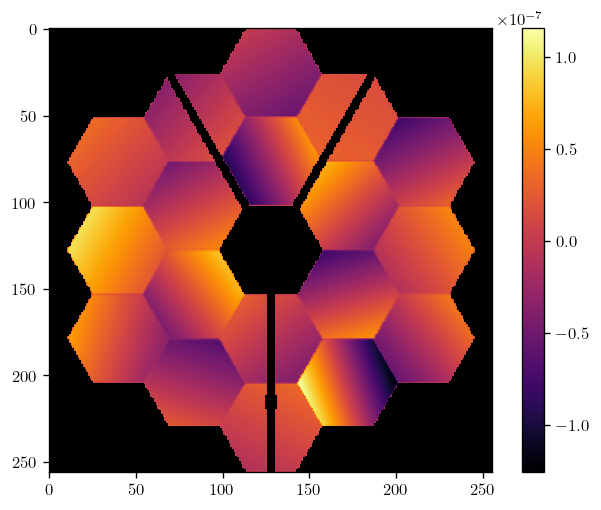

In [49]:
base_aberrations = get_aber(coeffs, basis_flat)
i_mask = np.where(telescope.pupil.transmission == 0, np.nan, telescope.pupil.transmission)
plt.imshow(base_aberrations * i_mask, cmap=cmap_v)
plt.colorbar()

In [50]:
@jit
def model_optics_jit():
    return telescope.model()

In [51]:
%%time
print("Modelling optics...")
psf = model_optics_jit()
print("Modelling optics...ok")

Modelling optics...
Modelling optics...ok
CPU times: user 1.68 s, sys: 950 ms, total: 2.63 s
Wall time: 1.53 s


In [52]:
psf_photon = jr.poisson(jr.PRNGKey(0), psf)
bg_noise = 0.01*jr.normal(jr.PRNGKey(0), psf_photon.shape)
data_n = psf_photon # + bg_noise

data = norm(data_n)

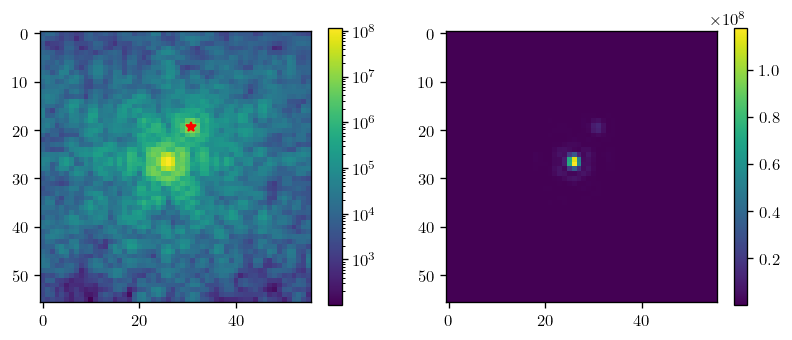

In [53]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.imshow(psf, norm="log")
plt.colorbar()

plt.plot(toPix(pri_x), toPix(-pri_y), marker='*', color="red")

plt.subplot(1, 2, 2)
plt.imshow(psf)
plt.colorbar()

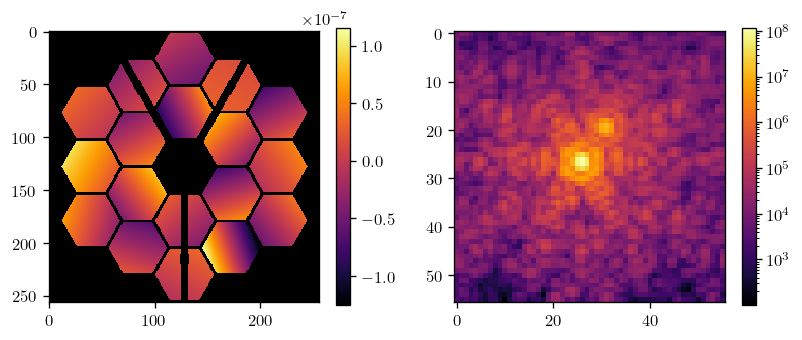

In [54]:
i_mask = np.where(telescope.pupil.transmission < 1, np.nan, telescope.pupil.transmission)

#coeffs = 2e-7*jr.normal(jr.PRNGKey(seed), (basis_flat.shape[0],))
#coeffs = np.zeros(basis_flat.shape[0])

#base_aberrations = get_aber(coeffs, basis_flat)
#telescope = telescope.set(['pupil.coefficients'], [coeffs])

psf = telescope.model()

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.imshow(base_aberrations * i_mask, cmap=cmap_v)
plt.colorbar()


plt.subplot(1, 2, 2)
plt.imshow(psf, cmap=cmap_v, norm="log")
plt.colorbar()

Now as we got fake data, lets tru to grid search the star position so we can pass it to the HMC as initial guess. 

In [55]:
model = telescope_clean

def likelihood(x, y, separation, angle, expected_data):
    model_data_n = model.set(['source.position'], [np.array([x, y])]).model()
    model_data = norm(model_data_n)
    residuals = expected_data - model_data
    # calculate the chi-squared value
    chi_squared = np.sum(residuals**2)
    # calculate the likelihood
    likelihood =  -0.5 * chi_squared
    return likelihood

#Make jitted version of likelihood function by using some lax magic
@jit
def likelihood_fast(x, y, separation, angle, expected_data):
    likelihood_c = lambda args : likelihood(args[0], args[1], args[2], args[3], expected_data)
    args = np.stack((x, y, separation, angle), axis=-1)
    return lax.map(likelihood_c, args)

First we search for the position of the primary star

In [56]:
def get_single(xr, yr):
    return likelihood_fast(xr, yr, np.zeros_like(xr), np.zeros_like(xr), data)

In [57]:
def fit_image(
    model,
    args,
    loss_fn,
    # grad_fn,
    norm_fn,
    epochs,
    config,
    verbose=True,
    print_grads=False,
):
    params = list(config.keys())
    optimisers = list(config.values())

    model = zdx.set_array(model, params)
    optim, opt_state = zdx.get_optimiser(model, params, optimisers)

    # if verbose:
    #     print("Compiling...")
    loss, grads = loss_fn(model, args)
    if print_grads:
        for param in params:
            print(f"{param}: {grads.get(param)}")
    losses, models_out = [], [model]

    if verbose:
        looper = tqdm(range(epochs), desc="Loss %.2f" % (loss))
    else:
        looper = range(epochs)

    for i in looper:
        # calculate the loss and gradient
        loss, grads = loss_fn(model, args)
        
        if print_grads:
            for param in params:
                print(f"{param}: {grads.get(param)}")
                
        if np.isnan(loss):
            print(f"Loss is NaN on {i} th epoch")
            return losses, models_out

        # # Apply any processing to the gradients
        # grads = grad_fn(grads, config, i)

        # apply the update
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)

        # Apply normalisation
        model = norm_fn(model)

        # save results
        models_out.append(model)
        losses.append(loss)

        if verbose:
            looper.set_description("Loss %.2E" % (loss))

    return losses, models_out

In [58]:
def format_fn(params_out, param):
    arr = np.array(params_out[param])
    if param == "position":
        return arr - arr[0]
    if "coefficient" in param:
        return arr.reshape(len(arr), -1)
    if "IPC.kernel" in param:
        arr = arr.at[:, 2, 2].add(-1)
        return arr.reshape(len(arr), -1)
    if "BFE.coeffs" in param:
        return arr.reshape(len(arr), -1)
    if "pupil_mask.holes" in param:
        arr = arr.reshape(len(arr), -1)
        return arr - arr[0]
    if 'OneOnF' in param:
        return arr.reshape(len(arr), -1)

    return arr

In [59]:
def plot_params(losses, params_out, format_fn, k=10, l=-1):
    # nparams = len(params_out.keys())
    # nplots = (nparams + 1) // 2

    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.title("Full Loss")
    plt.plot(losses)

    if k >= len(losses):
        k = 0
    last_losses = losses[k:l]
    n = len(last_losses)
    plt.subplot(1, 2, 2)
    plt.title(f"Final {n} Losses")
    plt.plot(np.arange(k, k + n), last_losses)

    plt.tight_layout()
    plt.show()

    params = list(params_out.keys())
    for i in np.arange(0, len(params), 2):
        plt.figure(figsize=(16, 5))
        plt.subplot(1, 2, 1)
        plt.title(params[i])
        plt.plot(format_fn(params_out, params[i]))

        plt.subplot(1, 2, 2)
        if i + 1 == len(params):
            plt.tight_layout()
            plt.show()
            break
        plt.title(params[i + 1])
        plt.plot(format_fn(params_out, params[i + 1]))

        plt.tight_layout()
        plt.show()

In [60]:
def nan_edges(im, edge_mask):
    im = im.at[:edge_mask].set(np.nan)
    im = im.at[-edge_mask:].set(np.nan)
    im = im.at[:, :edge_mask].set(np.nan)
    im = im.at[:, -edge_mask:].set(np.nan)
    return im

In [61]:
# Normalise the various components of the model
def norm_fn(model):
    return model

/root/miniconda3/envs/dlux_env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


Solving...


Loss 33767496713944080.00:   0%|          | 0/1500 [00:00<?, ?it/s]

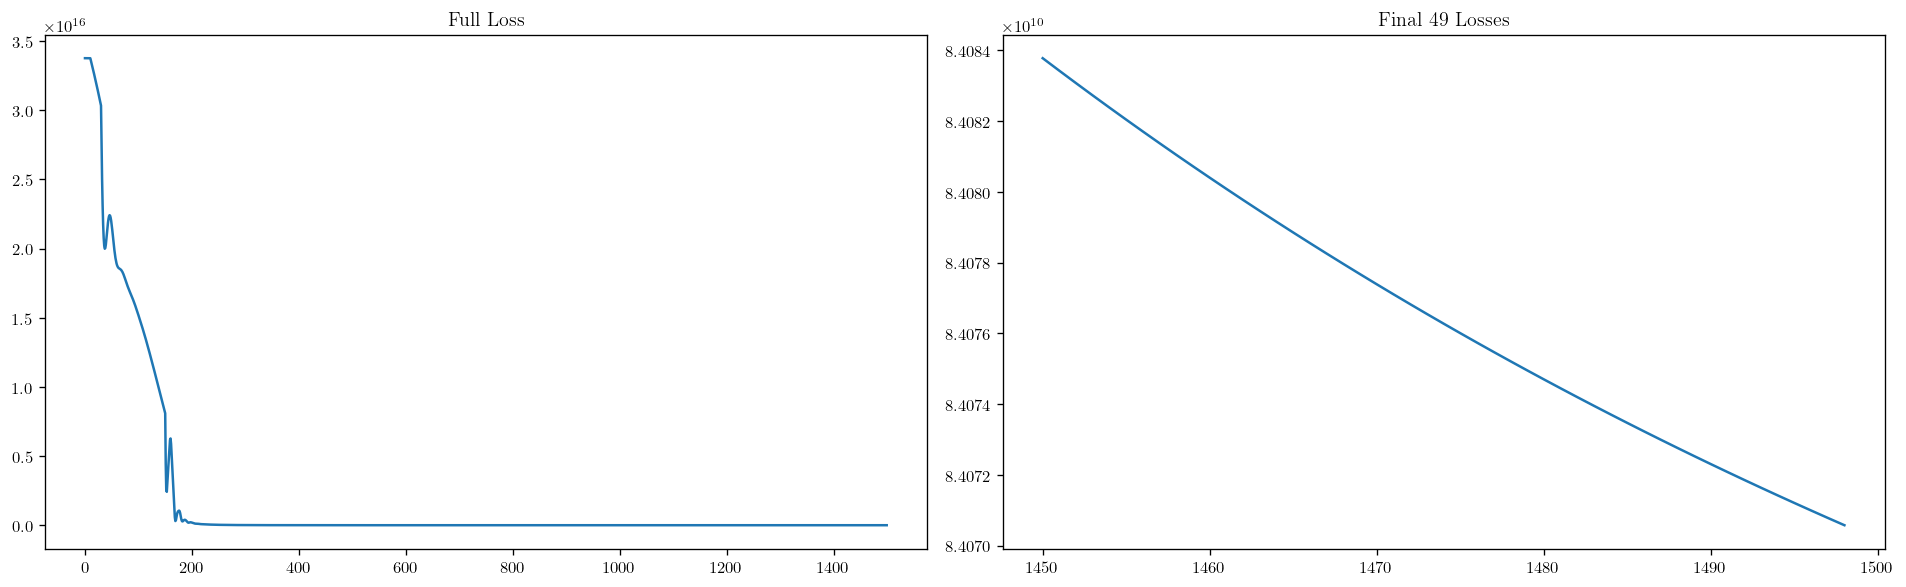

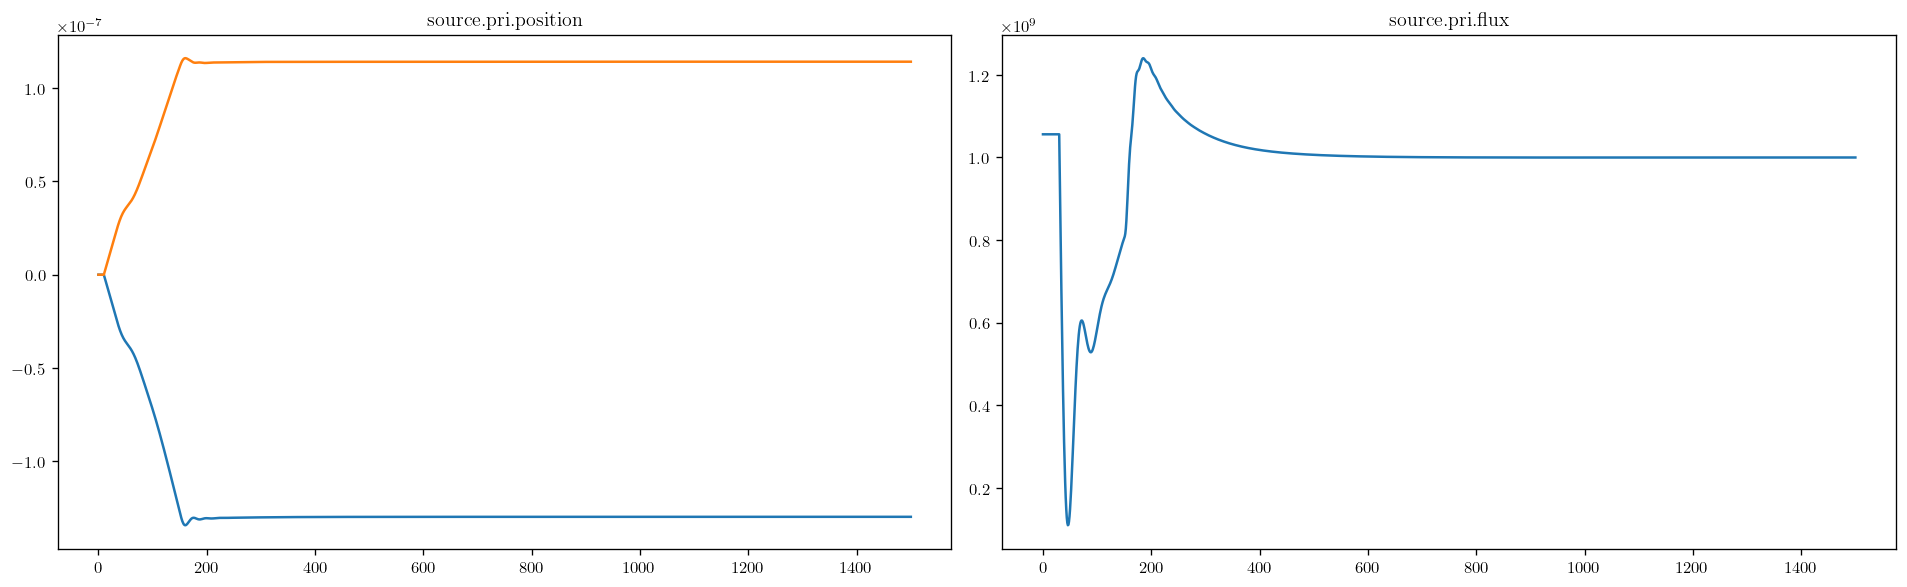

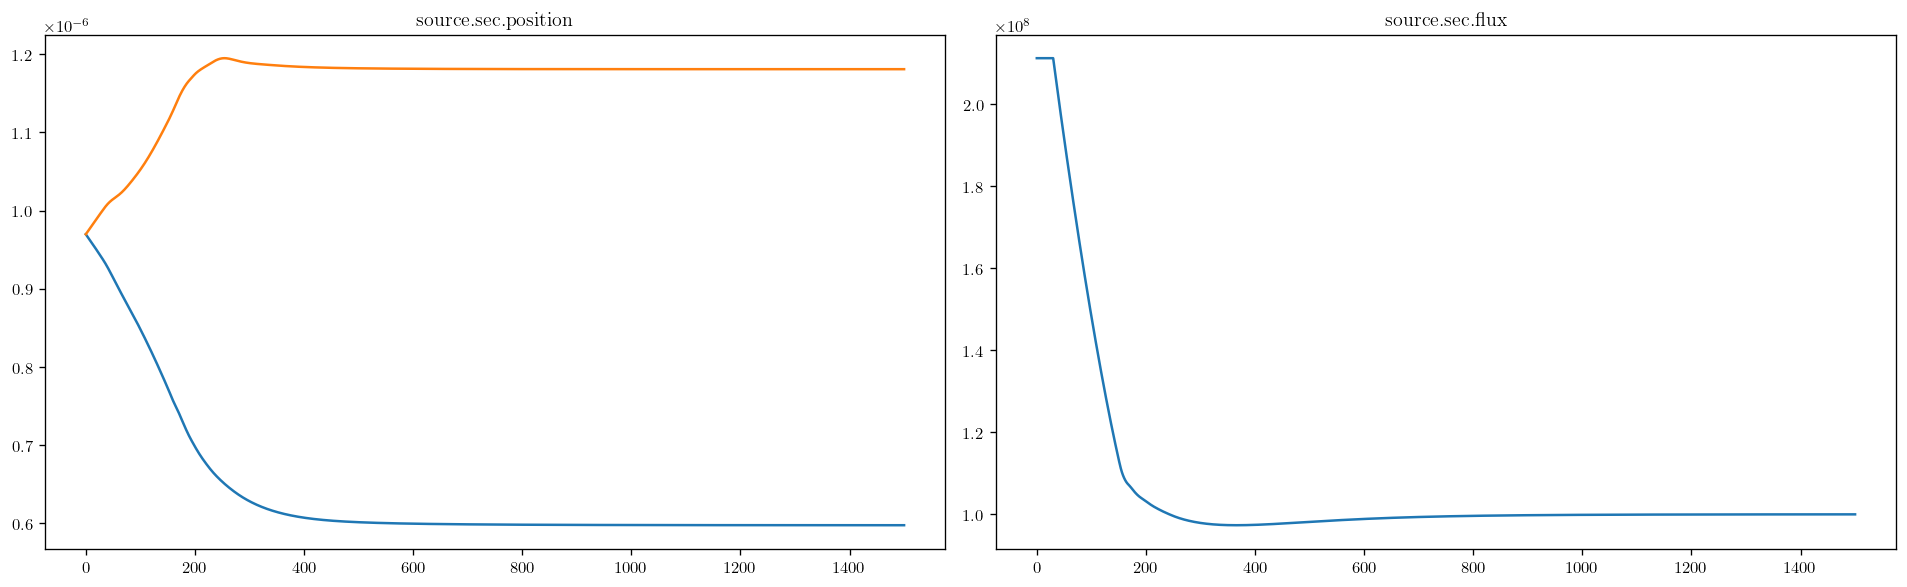

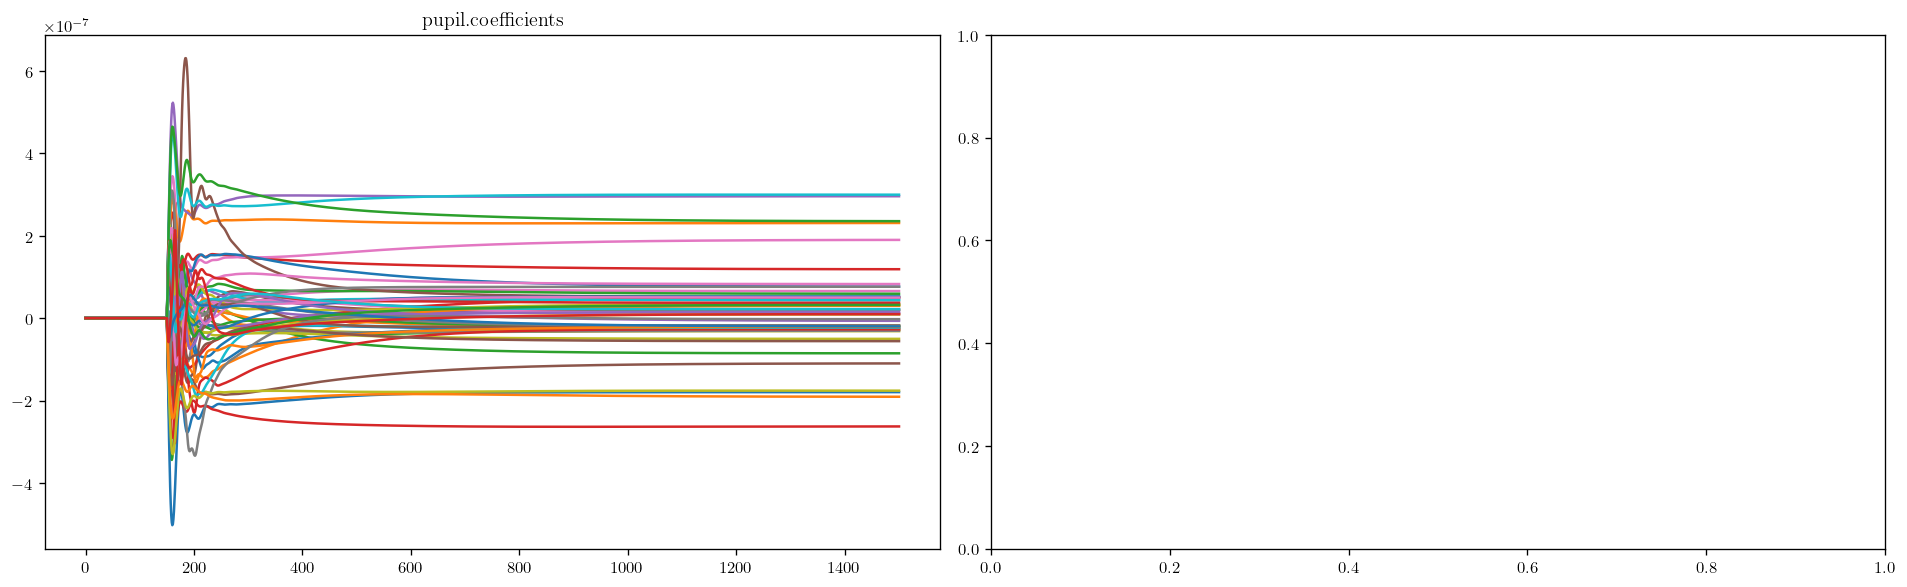

In [62]:
std = np.sqrt(data_n)
std = np.where(std == 0, np.mean(std), std)

im = data_n
err = std

im = nan_edges(im, 4)

support_mask = ~np.isnan(im)
support = np.where(support_mask)

# pos_arcsec = np.array([4e-07, 1e-06])
f = np.float64(np.sum(data_n))

model = telescope_clean

model = model.set(['source.pri.position'], [[0., 0.]])
model = model.set(['source.pri.flux'], [f])

model = model.set(['source.sec.position'], [[toRad(0.2), toRad(0.2)]])
model = model.set(['source.sec.flux'], [f/5])


# TODO: Investigate adamw -> Decrease learning rate over time, should act as a
# dampener, promoting convergence?
delay = lambda lr, s: optax.piecewise_constant_schedule(lr * 1e-16, {s:1e16})
config = {
    'source.pri.position':     optax.adam(delay(1e-9, 10)),
    'source.pri.flux':         optax.adam(delay(1e8, 30)),

    'source.sec.position':     optax.adam(delay(1e-9, 0)),
    'source.sec.flux':         optax.adam(delay(1e6, 30)),

    'pupil.coefficients':      optax.adam(delay(5e-8, 150)),
    
    #'source.flux':             optax.adam(delay(2e8, 20)),
    #'bg.value':         optax.adam(delay(1e1, 3)),
    #'BFE.coeffs.1':     optax.adam(delay(1e-2, 30)),
    #'BFE.coeffs.2':     optax.adam(delay(1e-6, 30)),

    #'OneOnF.coeffs':    optax.adam(delay(1e0, 50)),
}

spec = jtu.tree_map(lambda leaf: False, model).set(list(config.keys()), True)
model, _model = eqx.partition(model, spec)

# Loss function
def loss_fn(model, args):
    '''Should the flux gradients out of this be scaled by the norm factor?'''
    # Get the arg values
    _model, data, err = args
    # Recombine the model
    model = eqx.combine(model, _model)

    # # Calc normalisation factor
    # #norm = data[*support].sum()
    # # Apply the normalisation
    # x = model.model()[*support]
    # loc = data[*support]
    # scale = err[*support]

    # # Return the loss
    # return - jsp.stats.norm.logpdf(x, loc=loc, scale=scale).mean()

    model_data = model.model()[*support]
    residuals = data[*support] - model_data
    # calculate the chi-squared value
    chi_squared = np.sum(residuals**2)
    # calculate the likelihood
    likelihood =  0.5 * chi_squared
    return likelihood

############
############
############

loss_fn_in = zdx.filter_jit(zdx.filter_value_and_grad(list(config.keys()))(loss_fn))

# Optimisation
print("Solving...")
epochs = 1500

losses, models_out = fit_image(model, (_model, im, err), loss_fn_in, norm_fn, epochs, config, print_grads=False)

# Get the params from each model
params_out = {}
for param in config.keys():
    params_out[param] = [model.get(param) for model in models_out]

final_model = eqx.combine(models_out[-1], _model)

plot_params(np.array(losses), params_out, format_fn, k = epochs-50)

psf_found = final_model.model()



In [63]:

print(f'Pri Pos: {telescope.source.pri.position}')
print(f'Pri Pos: {final_model.source.pri.position}')

print(f'Sec Pos: {telescope.source.sec.position}')
print(f'Sec Pos: {final_model.source.sec.position}')

print(f'Pri Flux: {telescope.source.pri.flux}')
print(f'Pri Flux: {final_model.source.pri.flux}')

print(f'Sec Flux: {telescope.source.pri.flux}')
print(f'Sec Flux: {final_model.source.pri.flux}')

print(f'Contrast: {final_model.source.pri.flux/final_model.source.sec.flux}')

Pri Pos: [-2.42406841e-07  1.45444104e-07]
Pri Pos: [Array(-1.29627612e-07, dtype=float64), Array(1.14052642e-07, dtype=float64)]
Sec Pos: [4.84813681e-07 1.21203420e-06]
Sec Pos: [Array(5.97650543e-07, dtype=float64), Array(1.18066117e-06, dtype=float64)]
Pri Flux: 1000000000.0
Pri Flux: 999910524.2608502
Sec Flux: 1000000000.0
Sec Flux: 999910524.2608502
Contrast: 10.00150728867456


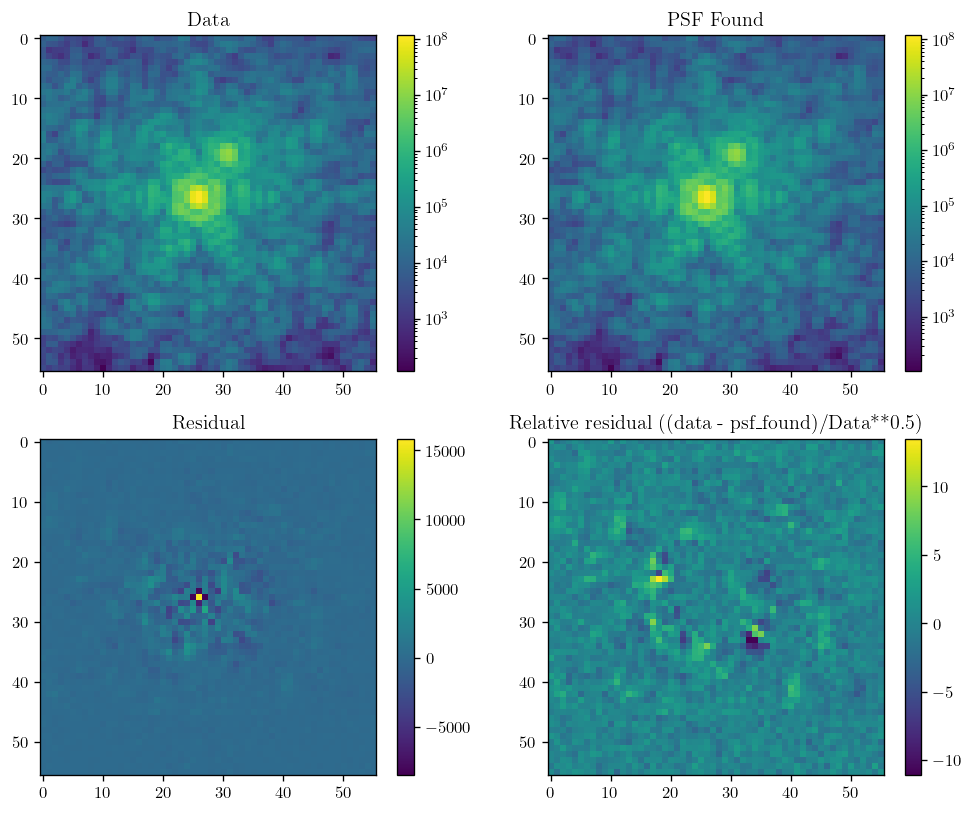

In [64]:

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)

plt.imshow(data_n, norm='log')
plt.colorbar()
plt.title("Data")

plt.subplot(2, 2, 2)

plt.imshow(psf_found, norm='log')
plt.colorbar()
plt.title("PSF Found")

plt.subplot(2, 2, 3)
plt.imshow(data_n - psf_found)
plt.colorbar()
plt.title("Residual")

plt.subplot(2, 2, 4)

residual = data_n - psf_found
rel_resid = residual / data_n**0.5
plt.imshow(rel_resid)
plt.colorbar()
plt.title("Relative residual ((data - psf_found)/Data**0.5)")

plt.show()

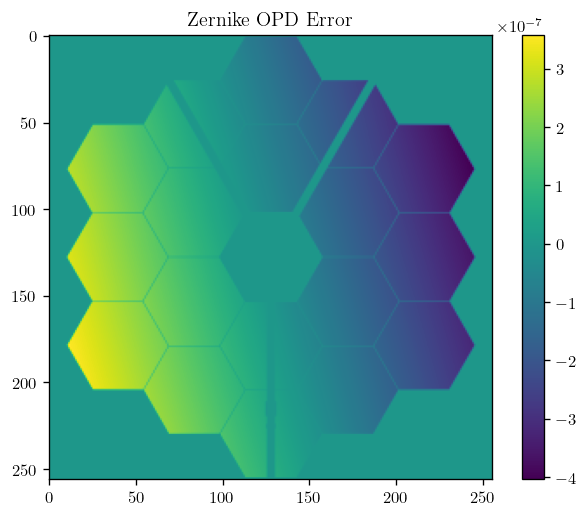

In [65]:
coeffs_pred_all = final_model.pupil.coefficients

base_aberrations = get_aber(coeffs, basis_flat)
rec_aberrations = get_aber(coeffs_pred_all, basis_flat)

plt.title("Zernike OPD Error")
plt.imshow((base_aberrations-rec_aberrations)*telescope.pupil.transmission)

plt.colorbar()

In [66]:
def plot_corellation(order, label):
    plot_coeffs = coeffs[order::zernike_terms]
    plot_coeffs_rec = coeffs_pred_all[order::zernike_terms]

    fig = plt.figure(constrained_layout=True,figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(plot_coeffs*1e9, plot_coeffs_rec*1e9,'.', markersize=12,color='C0',label='Recovered')
    ax.plot(plot_coeffs*1e9, np.zeros(len(plot_coeffs))*1e9,'.', markersize=12,color='C1',label='Initial')

    ax.plot(np.array([np.min(plot_coeffs),np.max(plot_coeffs)])*1e9,
                   np.array([np.min(plot_coeffs),np.max(plot_coeffs)])*1e9,
                   '-',color='C2',label='1:1')
    ax.legend()
    ax.set_title(f'Correlation Plot {label}')

    ax.set_xlabel('True Zernike Coefficients (nm)')
    ax.set_ylabel('Model Zernike Coefficients (nm)')

    plt.show()

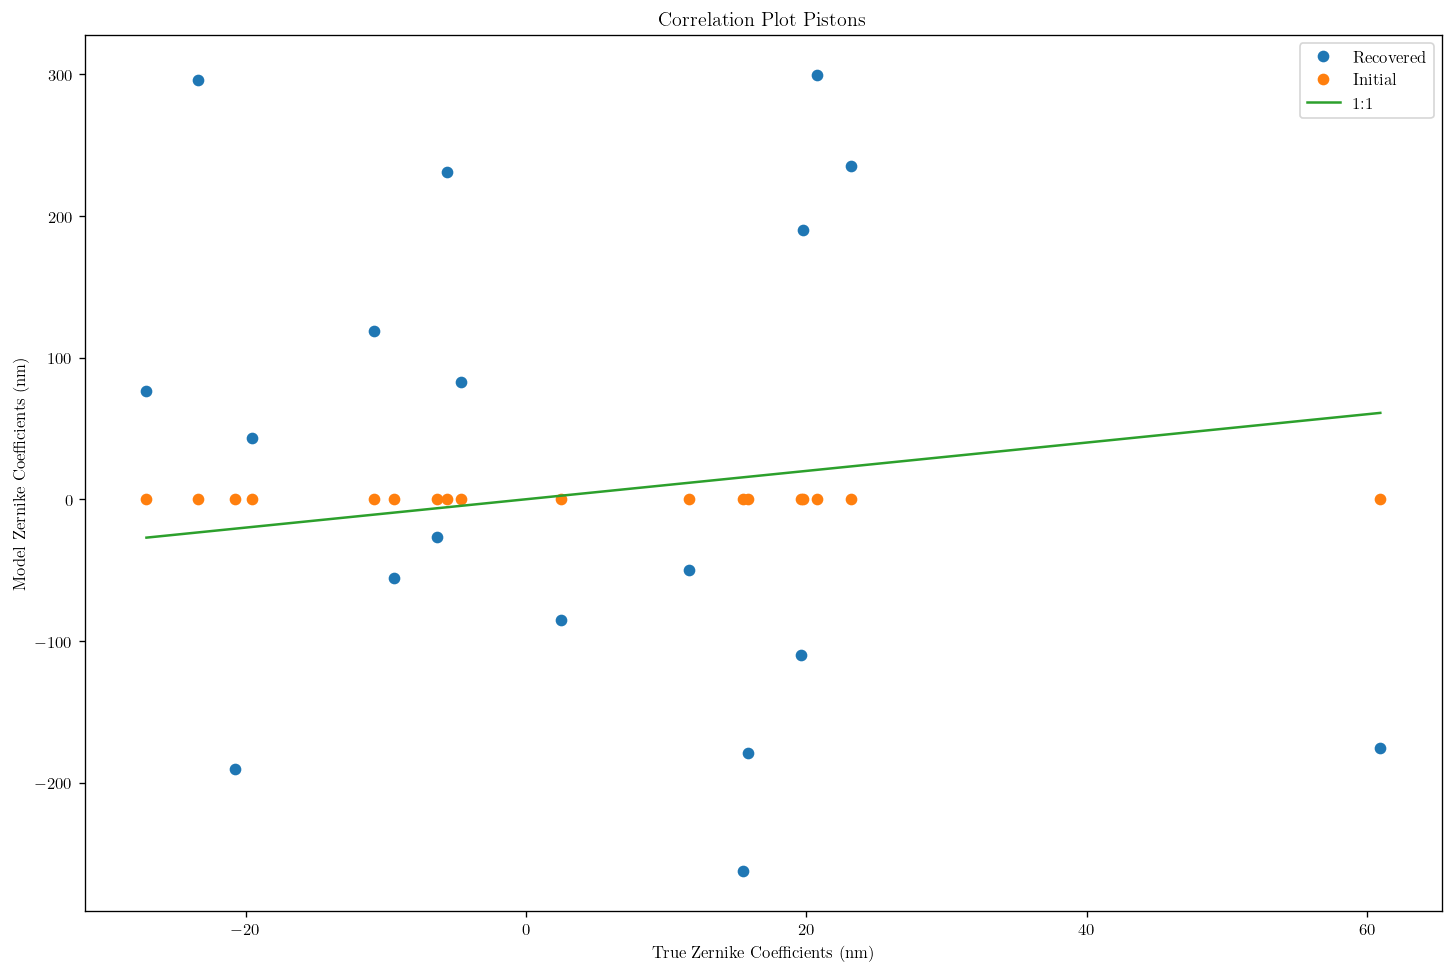

In [67]:
plot_corellation(0, 'Pistons')

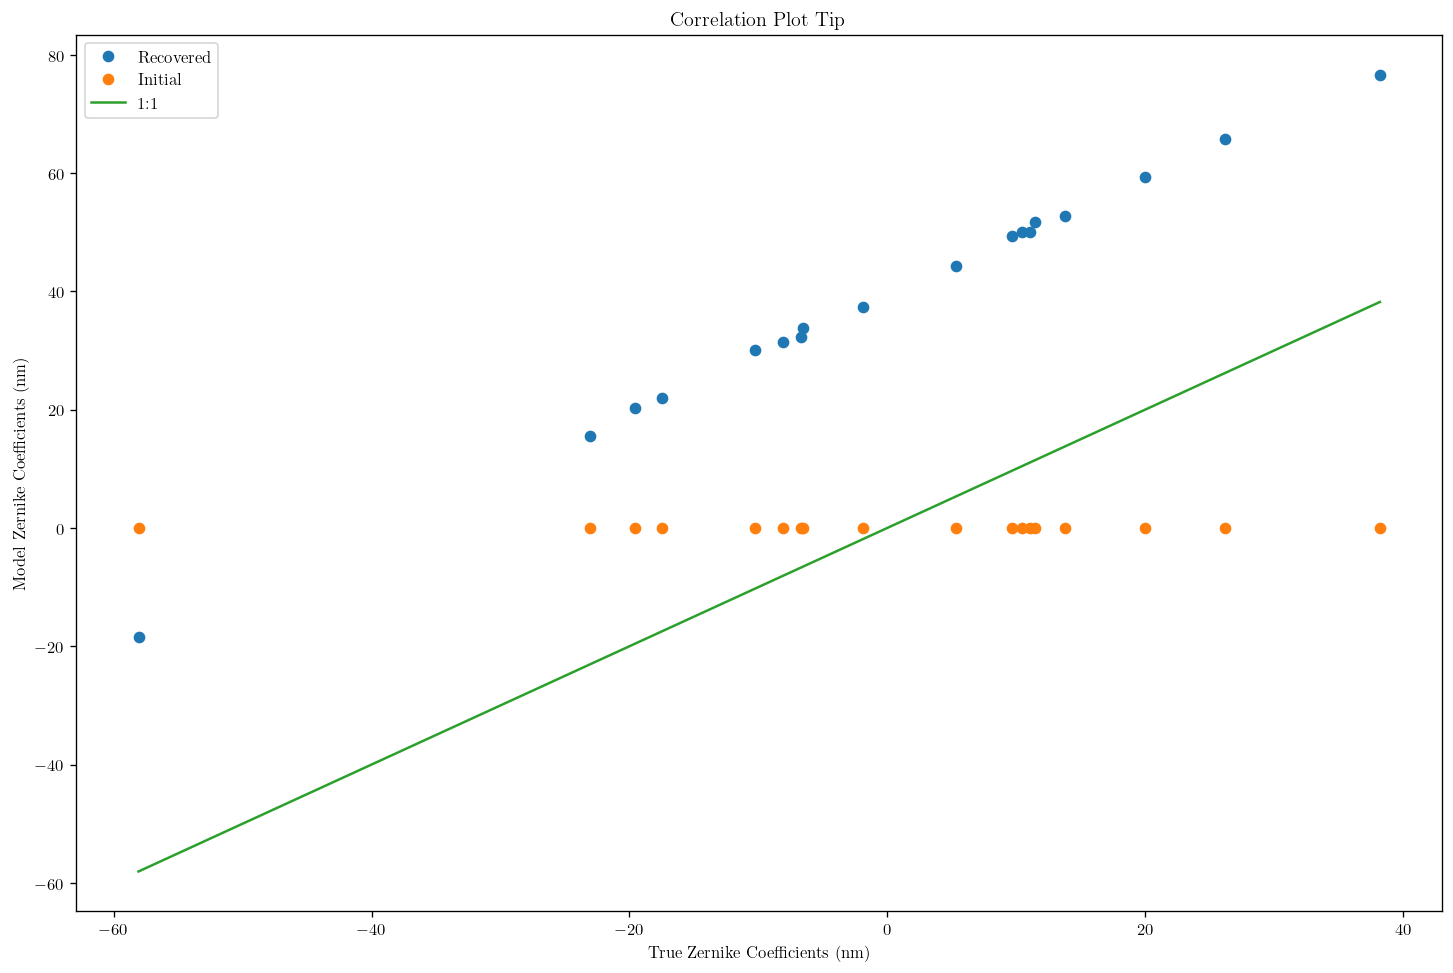

In [68]:
plot_corellation(1, 'Tip')

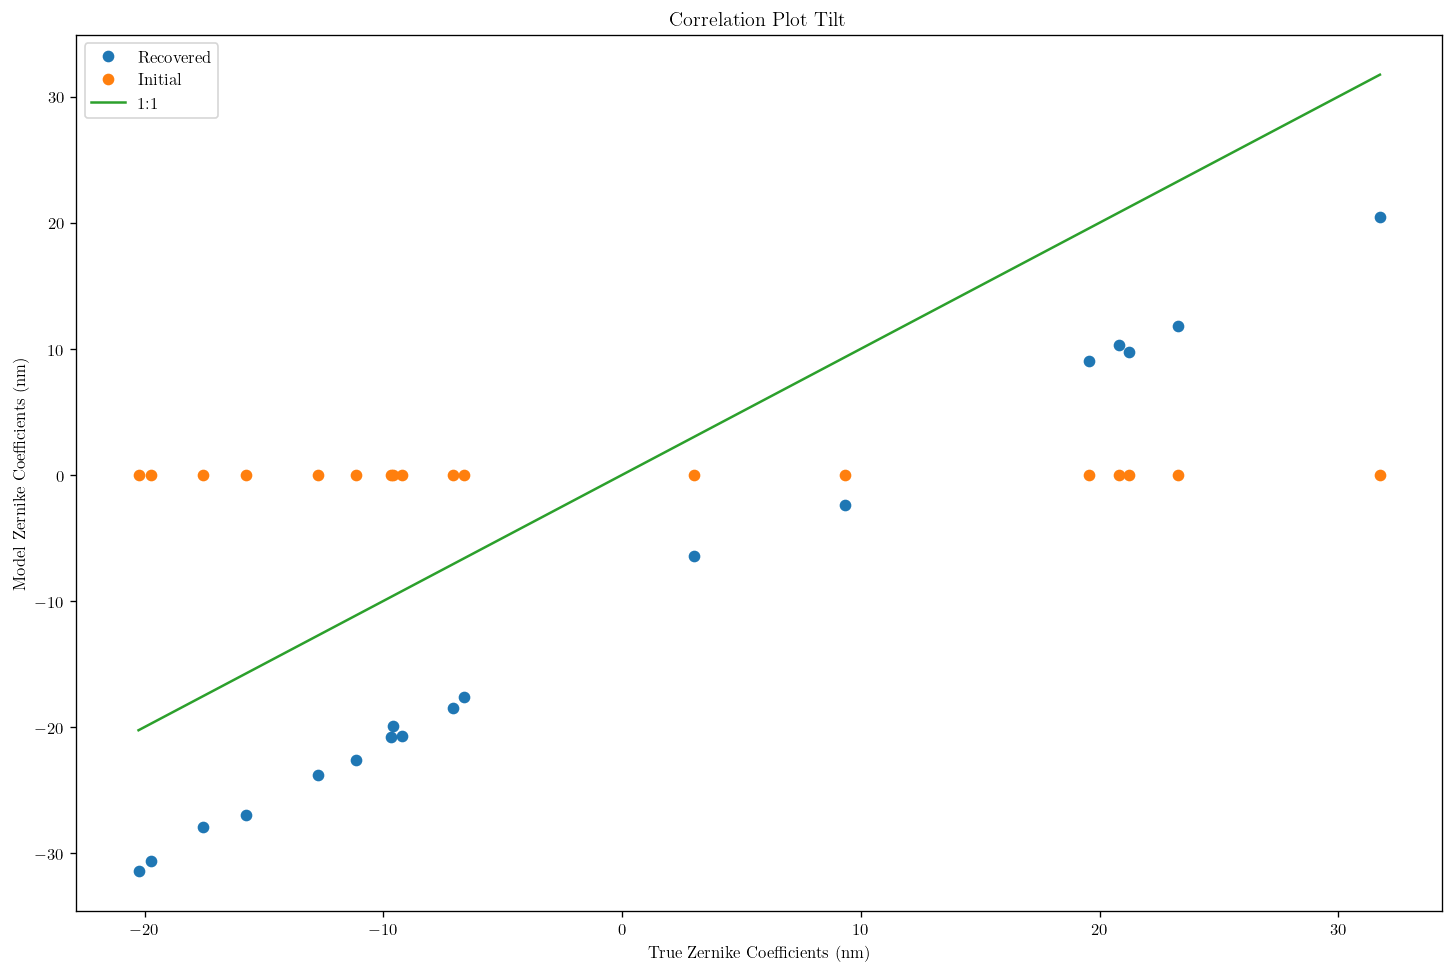

In [69]:
plot_corellation(2, 'Tilt')

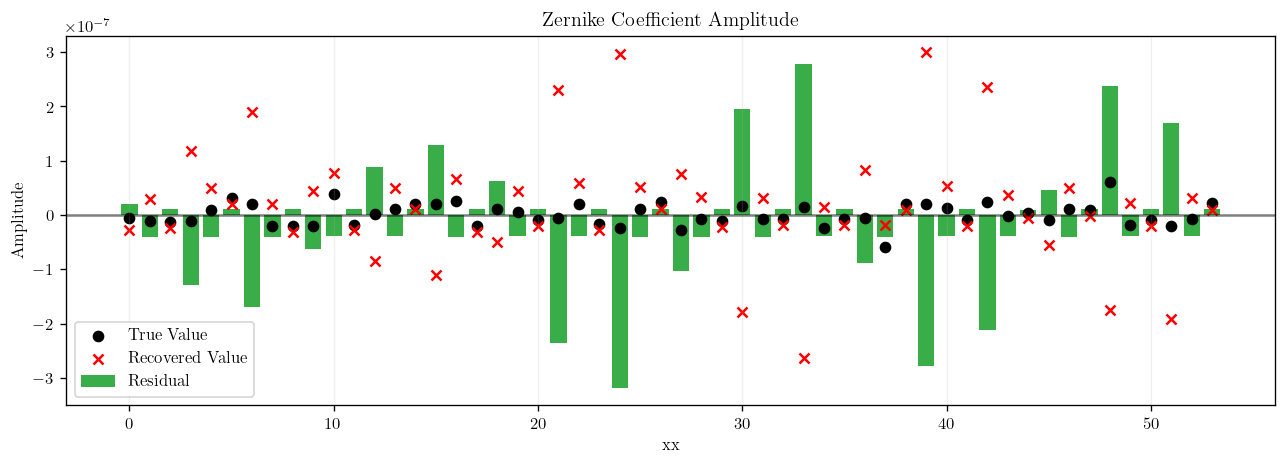

In [70]:
n_coeffs = 18 * zernike_terms

index = np.arange(0, n_coeffs)

plt.figure(figsize=(13, 4))
plt.title("Zernike Coefficient Amplitude")
plt.xlabel("xx")
plt.ylabel("Amplitude")

plt.grid(alpha=0.2, axis='x')
plt.scatter(index, coeffs, label="True Value", c='k')
plt.scatter(index, coeffs_pred_all, label="Recovered Value", marker='x', c='red')
plt.bar(index, coeffs -coeffs_pred_all, label='Residual', color='#39ad48', zorder=-1)
plt.axhline(0, c='k', alpha=0.5)
plt.legend()
plt.savefig('coefficients.pdf', dpi=300)
plt.show()